## IMPORTING THE LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import warnings
import os

from datetime import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,mean_squared_log_error
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
%matplotlib inline

## HELPER FUNCTIONS

In [2]:
def get_data():
    train = pd.read_csv('https://s3.us-east-2.amazonaws.com/final-project-dataset/train.csv')
    test = pd.read_csv('https://s3.us-east-2.amazonaws.com/final-project-dataset/test.csv')
    return train, test

In [3]:
def preprocessing_data(train,test):
    global categoricalFeatureNames,numericalFeatureNames
    
    #Combining Test and Train Frames
    data = train.append(test)
    data.reset_index(inplace=True)
    data.drop('index',inplace=True,axis=1)
    
    #Deriving Time Series Columns from datetime field
    data["date"] = data.datetime.apply(lambda x : x.split()[0])
    data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
    data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0]).astype('int')
    data["weekday"] = data.date.apply(lambda dateString : dt.strptime(dateString,"%Y-%m-%d").weekday())
    data["month"] = data.date.apply(lambda dateString : dt.strptime(dateString,"%Y-%m-%d").month)
    
    #Predicting Missing Wind Values using RF Regressor
    dataWind0 = data[data["windspeed"]==0]
    dataWindNot0 = data[data["windspeed"]!=0]
    rfModel_wind = RandomForestRegressor()
    windColumns = ["season","weather","humidity","month","temp","year","atemp"]
    rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])
    wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
    dataWind0["windspeed"] = wind0Values
    data = dataWindNot0.append(dataWind0)
    data.reset_index(inplace=True)
    data.drop('index',inplace=True,axis=1)
    
    #Designating Categorical Features from numeric columns
    categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
    numericalFeatureNames = ["atemp","humidity","windspeed","casual","registered"]
    dropFeatures = ["datetime","date","temp","count"]
    
    for var in categoricalFeatureNames:
        data[var] = data[var].astype("category")
    
    dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
    dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
    
    dataTrain  = dataTrain.drop(dropFeatures,axis=1)
    dataTest  = dataTest.drop(dropFeatures,axis=1)
    dataTest = dataTest.drop(['casual','registered'],axis=1)
    
    return dataTrain,dataTest

In [4]:
error_metric2 = pd.DataFrame({'Training RMSLE': [],'Training R^2': [],'Testing RMSLE':[], 'Testing R^2':[]})

def model_stats(model, model_name, X_train, Y_train, X_test, Y_test):
    global error_metric2
    train_data_predictions = model.predict(X_train)
    test_data_predictions = model.predict(X_test)

    # RMSLE
    model_rmsle_train = np.sqrt(mean_squared_log_error(Y_train, train_data_predictions))
    model_rmsle_test = np.sqrt(mean_squared_log_error(Y_test, test_data_predictions))

    # R-Squared
    model_r2_train = r2_score(Y_train, train_data_predictions)
    model_r2_test = r2_score(Y_test, test_data_predictions)

    df_local = pd.DataFrame({'Model': [model_name],
                             'Training RMSLE': [model_rmsle_train],
                             'Training R^2': [model_r2_train],
                             'Testing RMSLE':[model_rmsle_test],
                             'Testing R^2' : [model_r2_test]})

    error_metric2 = pd.concat([error_metric2, df_local], sort=True)

## SEPARATING CASUAL AND REGISTERED TARGETS

In [5]:
raw_train, raw_test = get_data()
pro_train, pro_test = preprocessing_data(raw_train,raw_test)

In [6]:
X = pro_train.drop(['casual','registered'],axis=1)
y_casual = pro_train['casual']
y_registered = pro_train['registered']

## CASUAL USER PREDICTION

In [7]:
tuned_casual = RandomForestRegressor(n_estimators = 100, max_depth = 50, oob_score = False, n_jobs = -1)

In [8]:
X_train_cas, X_test_cas, y_train_cas, y_test_cas = train_test_split(X, y_casual, test_size=0.30, shuffle=False)

In [9]:
tuned_casual.fit(X_train_cas,y_train_cas)
model_stats(tuned_casual,'Model for Casual Prediction',X_train_cas,y_train_cas,X_test_cas,y_test_cas)

In [10]:
casual_predictions = tuned_casual.predict(pro_test)

## REGISTERED USER PREDICTION

In [11]:
tuned_reg = RandomForestRegressor(n_estimators = 100, max_depth = 50, oob_score = False, n_jobs = -1)

In [12]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_registered, test_size=0.30, shuffle=False)

In [13]:
tuned_reg.fit(X_train_reg,y_train_reg)
model_stats(tuned_reg,'Model for Registered Predictions',X_train_reg,y_train_reg,X_test_reg,y_test_reg)

In [14]:
registered_predictions = tuned_reg.predict(pro_test)

## PREPPING THE FINAL SUBMISSION DATAFRAME

In [15]:
reg_pred = pd.DataFrame(registered_predictions)
reg_pred.set_index(pro_test.index,inplace=True)
reg_pred.columns = ['registered_pred']

cas_pred = pd.DataFrame(casual_predictions)
cas_pred.set_index(pro_test.index,inplace=True)
cas_pred.columns = ['casual_pred']

In [16]:
pro_test = pd.concat([pro_test,reg_pred,cas_pred],axis=1)

In [17]:
pro_test['count'] = pro_test['registered_pred'] + pro_test['casual_pred']

In [18]:
pro_test = pro_test.reset_index().set_index(raw_test['datetime'])

In [21]:
pro_test['count'].to_csv("Summed Predictions.csv")

## METRICS FOR BOTH MODELS AND RANKING

In [23]:
error_metric2.reset_index().drop('index',axis=1)

,Model,Testing RMSLE,Testing R^2,Training RMSLE,Training R^2
0,Model for Casual Prediction,0.560197,0.810732,0.253871,0.987407
1,Model for Registered Predictions,0.353974,0.878212,0.154129,0.992567


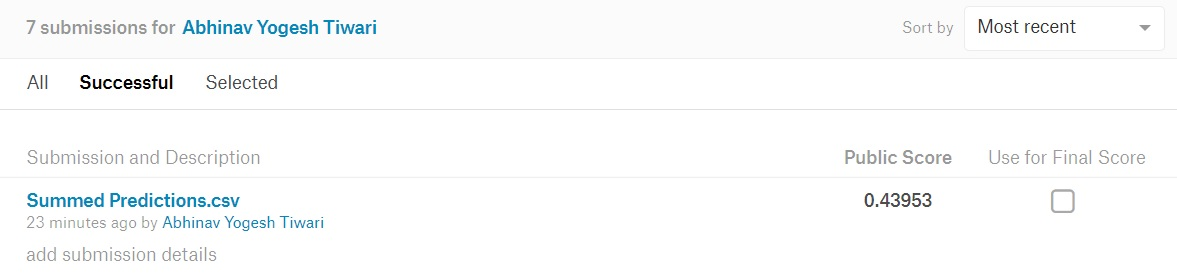